# Worked Examples
This notebook provides some examples of input compounds and the derived scaffold found to be highest-scoring in the database (DB), alongside explanations of these scores via details on the scaffold's associated compounds, substances and assays from PubChem.

## Background

### PubChem
PubChem (https://pubchem.ncbi.nlm.nih.gov/) is a public chemistry database maintained by the NIH. PubChem includes records for over 100 million compounds and data from over 1 million bioassays. 


For more information about PubChem see: https://pubchem.ncbi.nlm.nih.gov/docs/about

#### BioAssays
The PubChem bioassay database contains over 200 million bioassay outcomes across over 1 million bioassays. Assay data is deposited to PubChem from sources (including universities, government labs, pharmaceutical companies, etc) around the world. Each assay record is uniquely identified via its AssayID (AID).

For more info see: https://pubchem.ncbi.nlm.nih.gov/docs/bioassays

#### Substances
"Substance" refers to depositor-provided data for a chemical entity. Note that not all substances are necessarily compounds, e.g. [Green Tea Leaf](https://pubchem.ncbi.nlm.nih.gov/substance/482031919). Substances are uniquely identified via their SubstanceID (SID).

For more info see: https://pubchem.ncbi.nlm.nih.gov/docs/substances 

#### Compounds
A compound is a unique, discrete chemical structure obtained from one or more substances via a [standardization process](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4702940/#SEC3-2). One compound can be associated with 1 or more substances. Compounds are uniquely identified via their CompoundID (CID).

For more info see: https://pubchem.ncbi.nlm.nih.gov/docs/compounds 

### Badapple (bioassay-data associative promiscuity pattern learning engine)
Badapple is a statistical method for identifying likely promiscuous compounds via their associated scaffolds, using data gathered from PubChem, and in particular data from the [Molecular Libraries Small Molecules Program](https://pubchem.ncbi.nlm.nih.gov/source/MLSMR).

Original Badapple paper: https://jcheminf.biomedcentral.com/articles/10.1186/s13321-016-0137-3

#### Badapple Score Calculation
Based on the data gathered from PubChem, badapple calculates a "promiscuity score" (pscore) for a given scaffold using the following formula:

$$
\begin{aligned} pscore & = \frac{{s_{A} }}{{s_{T} + med(s_{T} )}} \times \frac{{a_{A} }}{{a_{T} + med(a_{T} )}} \quad \times \frac{{w_{A} }}{{w_{T} + med(w_{T} )}} \times 1e5 \\ \end{aligned}
$$

Where:
| Symbol       | Description                      | Value |
|--------------|----------------------------------|-------|
| $s_{T}$      | tested substances                |       |
| $s_{A}$      | active substances                |       |
| $a_{T}$      | assays with tested compounds     |       |
| $a_{A}$      | assays with active compounds     |       |
| $w_{T}$      | tested samples                   |       |
| $w_{A}$      | active samples                   |       |
| $med$        | median                           |       |
| $med(s_{T})$ | median of tested substances       | 2     |
| $med(a_{T})$ | median of assays with tested compounds | 632   |
| $med(w_{T})$ | median of tested samples          | 773   |

Note that "sample" here refers to an instance of a substance in an assay, i.e. a single bioactivity outcome.

#### Badapple score meaning
In Badapple, a higher score indicates a higher chance that a scaffold is promiscuous. The table below provides an overview of score ranges and their corresponding advisory:

| **pScore range** | **Advisory** |
|------------------|--------------|
| ~                | Unknown; no data |
| 0–99             | Low pScore; no indication |
| 100–299          | Moderate pScore; weak indication of promiscuity |
| 300+             | High pScore; strong indication of promiscuity |

Note that the pscore for a given scaffold will only be high if there is a large amount of evidence, given the medians in the denominator. One can see from the figure below that scores cannot pass in the "Moderate" and "High" range without surpassing the number of assays tested surpassing a certain threshold:

![Image not Found!](src/notebooks/badapple_formula.png)

(ignore the `median_aTested` number in the figure, it is outdated)

#### Example score calculations
If a scaffold is only present in one substance that is active in one assay then the pscore will not be high:
$$
\begin{aligned} \frac{{1 }}{{1 + med(s_{T} )}} \times \frac{1}{{1 + med(a_{T} )}} \quad \times \frac{{1 }}{{1 + med(w_{T} )}} \times 1e5  = 0.07 \\ \end{aligned}
$$

On the other hand, if a scaffold is present in 70 tested substances across 600 different assays for a total of $600*70=42000$ samples, and 50/70 of those substances are active in 500/600 of the assays in a total of $30000$ samples* then the score will be high:
$$
\begin{aligned} \frac{{50}}{{70 + med(s_{T} )}} \times \frac{500}{{600 + med(a_{T} )}} \quad \times \frac{{30000 }}{{42000 + med(w_{T} )}} \times 1e5 = 1976.73 \\ \end{aligned}
$$

*Note that the number of samples per substance can vary

## Code Setup
Imports, function definitions. This code uses the [Badapple2-API](https://github.com/unmtransinfo/Badapple2-API) to fetch information from the DB.

In [1]:
BASE_URL = "http://localhost:8000/api/v1"

In [2]:
# imports
import requests
from rdkit import Chem
import pandas as pd
from IPython.display import display, HTML

In [3]:
def get_request_data(request_url: str):
    result = requests.get(request_url)
    res = {}
    if result.status_code == 200:
        res = result.json()
    else:
        print(result)
    return res

In [4]:
def get_mol_scaffolds(mol_smiles: str):
    request_url = f"{BASE_URL}/compound_search/get_associated_scaffolds?SMILES={mol_smiles}"
    return get_request_data(request_url)

In [5]:
def get_associated_pubchem_compounds(scafid: int):
    request_url = f"{BASE_URL}/scaffold_search/get_associated_compounds?scafid={scafid}"
    return get_request_data(request_url)

In [6]:
def get_associated_pubchem_substances(cid_list: list[int]):
    formatted_inp = ','.join(str(cid) for cid in cid_list)
    request_url = f"{BASE_URL}/compound_search/get_associated_substance_ids?CIDs={formatted_inp}"
    return get_request_data(request_url)

In [7]:
def get_assay_outcomes(sid: int):
    request_url = f"http://localhost:8000/api/v1/substance_search/get_assay_outcomes?SID={sid}"
    return get_request_data(request_url)

In [8]:
def create_clickable_urls(id_list: int, base_url: str):
    if isinstance(id_list, int):
        id_list = [id_list]
    return [f'<a href="{base_url}{ID}" target="_blank">{ID}</a>'  for ID in id_list]

In [9]:
# create df that has clickable links to PubChem pages for Compounds, Substances, and Assays
def create_clickable_df(df_og: pd.DataFrame, id_cols: list[str], base_urls: list[str]):
    df = df_og.copy()
    for col, base_url in zip(id_cols, base_urls):
        df[col] = df[col].apply(lambda ids: create_clickable_urls(ids, base_url))
        df[col] = df[col].apply(lambda urls: ', '.join(urls))
    return display(HTML(df.to_html(escape=False)))

In [10]:
def get_scaf_legend(scaf_info: dict):
    s = f"SMILES: {scaf_info['scafsmi']}\n"
    s+= f"in_db: {scaf_info["in_db"]}"
    if scaf_info["in_db"]:
        s += f" | pscore {scaf_info["pscore"]} | ID: {scaf_info["id"]}"
    return s

In [11]:
def get_mol_scaf_grid(mol_smiles: str, scaf_info_list: list[dict]):
    # process mol
    mol_legend = f"Molecule SMILES = {mol_smiles}"
    mol = Chem.MolFromSmiles(mol_smiles)

    # process scafs
    scaf_mols = [Chem.MolFromSmiles(d['scafsmi']) for d in scaf_info_list]
    scaf_legends = [get_scaf_legend(d) for d in scaf_info_list]

    # combine and draw
    mol_matrix = [[mol]] + [[scaf] for scaf in scaf_mols]
    legend_matrix = [[mol_legend]] + [[legend] for legend in scaf_legends]
    return Chem.Draw.MolsMatrixToGridImage(molsMatrix=mol_matrix, legendsMatrix=legend_matrix, useSVG=True, subImgSize=(600, 300))

In [12]:
def get_mols_grid(mol_smiles_list: list[str], legends: list, mols_per_row: int):
    mols = [Chem.MolFromSmiles(smi) for smi in mol_smiles_list]
    img = Chem.Draw.MolsToGridImage(mols=mols, legends=legends, molsPerRow=mols_per_row, useSVG=True, subImgSize=(300, 300))
    return img

In [13]:
def compute_pscore(
    sTested: int,
    sActive: int,
    aTested: int,
    aActive: int,
    wTested: int,
    wActive: int,
    median_sTested: float = 2.0,
    median_aTested: float = 632,
    median_wTested: float = 773,
) -> float:
    if sTested == 0 or aTested == 0 or wTested == 0:
        return None  # None means no evidence

    pScore = (
        1.0
        * sActive
        / (sTested + median_sTested)
        * aActive
        / (aTested + median_aTested)
        * wActive
        / (wTested + median_wTested)
        * 1e5
    )
    pScore = round(pScore, 2)  # rounds to two decimal places
    return pScore

## Load data
Here we load in a set of molecules and their pscores. We pick out the molecule which had the scaffold with the highest pscore.

In [14]:
tsv_path = "/home/jack/unm_gra/tmp/dtra/vendor_compounds_scores.tsv"
df = pd.read_csv(tsv_path, sep="\t")

In [15]:
# molecule which contains scaffold w/ largest pscore
highest_pscore_mol_row = df.iloc[df["pscore"].argmax()]
highest_pscore_mol_smiles = highest_pscore_mol_row["SMILES"]
highest_pscore_mol_row

IDNUMBER                                            C620-0100
SMILES      CN(C)c1cc(NCCN2CCC3(CC2)OCCO3)c2c3c(onc13)-c1c...
pscore                                                2084.88
scafsmi                           O=C1c2ccccc2-c2onc3cccc1c23
scafid                                                20712.0
Name: 19858, dtype: object

## Visualize Molecule + all of its scaffolds

In [16]:
mol_scaffolds = get_mol_scaffolds(highest_pscore_mol_smiles)
# API returns dict mapping input SMILES to their list of scaffolds
mol_scaffolds = mol_scaffolds[highest_pscore_mol_smiles]

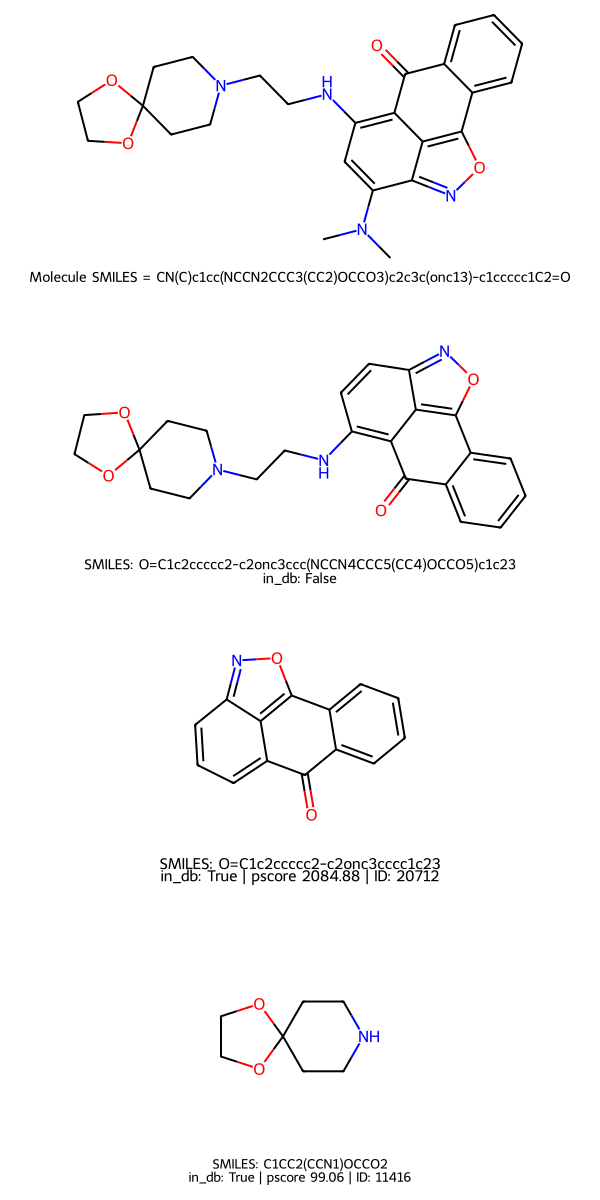

In [17]:
get_mol_scaf_grid(highest_pscore_mol_smiles, mol_scaffolds)

## Analysis of highest-scoring scaffold
The sections below dives into why the scaffold with SMILES `O=C1c2ccccc2-c2onc3cccc1c23` has been assigned the score that it has. In particular, we look at the statistics as well as all the associated PubChem compounds, substances, and assays that were found to be linked to this scaffold in the Badapple DB. 

In addition, there has been literature published about this particular scaffold, as identified in the original Badapple paper: "Scaffold a 6H-anthra[1,9-cd]isoxazol-6-one is known to react with DMSO acting as a nucleophile and undergoes N–O cleavage of the isoxazole ring to form the ring opened anthraquinone, a species known to form covalent adducts" (https://jcheminf.biomedcentral.com/articles/10.1186/s13321-016-0137-3/tables/7)

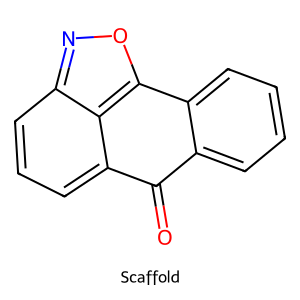

In [18]:
get_mols_grid([highest_pscore_mol_row["scafsmi"]], ["Scaffold"], 1)

In [19]:
scafid = int(highest_pscore_mol_row["scafid"])

In [20]:
COMPOUND_BASE_URL = "https://pubchem.ncbi.nlm.nih.gov/compound/"
SUBSTANCE_BASE_URL = "https://pubchem.ncbi.nlm.nih.gov/substance/"
ASSAY_BASE_URL = "https://pubchem.ncbi.nlm.nih.gov/bioassay/"

### Scaffold Details
Badapple contains not only the scores of a given scaffold, but also other information. The column titles are mostly self-descriptive (see background on Badapple above), although we note that `in_drug` denotes if the scaffold is found in any drugs from [DrugCentral](https://drugcentral.org/), which includes approved drugs from the FDA, EMA, and PMDA.

In [21]:
mol_scaffolds_df = pd.DataFrame(mol_scaffolds)
scaf_row_idx = mol_scaffolds_df.index[mol_scaffolds_df['id']==scafid][0]
scaf_row = mol_scaffolds_df.iloc[scaf_row_idx]
scaf_row

in_db                                 True
scafsmi        O=C1c2ccccc2-c2onc3cccc1c23
id                                 20712.0
in_drug                              False
nass_active                          352.0
nass_tested                          818.0
ncpd_active                           19.0
ncpd_tested                           19.0
ncpd_total                            20.0
nsam_active                         1154.0
nsam_tested                        10514.0
nsub_active                           21.0
nsub_tested                           23.0
nsub_total                            24.0
prank                                  8.0
pscore                             2084.88
scaftree                             20712
Name: 1, dtype: object

We can also see that the pscore calculation matches what we'd calculate from the statistics

In [22]:
print("pscore from DB:", scaf_row["pscore"])
calculated_pscore = compute_pscore(scaf_row["nsub_tested"], scaf_row["nsub_active"],
                                    scaf_row["nass_tested"], scaf_row["nass_active"],
                                    scaf_row["nsam_tested"], scaf_row["nsam_active"])
print("pscore calculated from stats:", calculated_pscore)

pscore from DB: 2084.88
pscore calculated from stats: 2084.88


### Compounds
Since this scaffold was found in the Badapple DB, we know it most be associated with 1 or more compounds from PubChem present in the DB. Here we view and get other information related to each of these associated compounds. By clicking on a given CID you can view additional information.

In [23]:
associated_compounds = get_associated_pubchem_compounds(scafid)
associated_compounds_df = pd.DataFrame(associated_compounds)
associated_compounds_df = associated_compounds_df.sort_values(by="cid").reset_index(drop=True)
associated_compounds_df = associated_compounds_df.rename(columns={"cid": "CID"})
associated_compounds_df = associated_compounds_df.drop(columns=["cansmi"]) # have isomeric SMILES

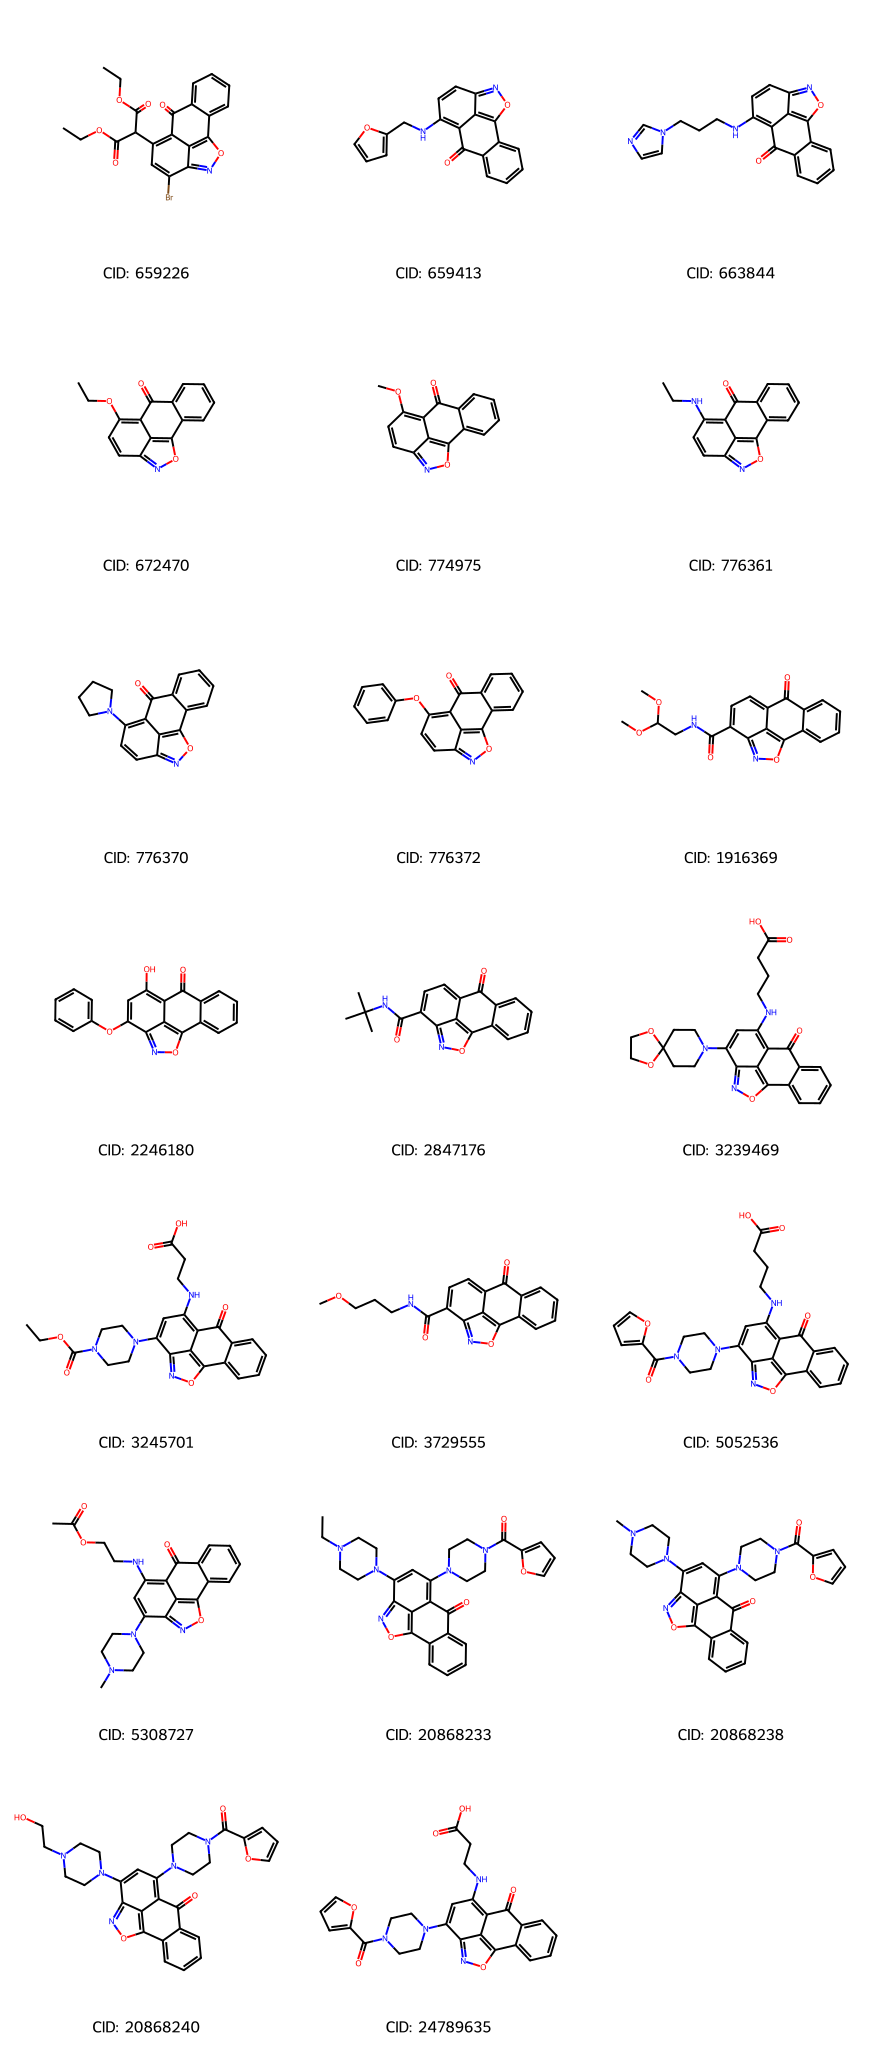

In [24]:
associated_compound_smiles = associated_compounds_df["isosmi"].tolist()
legends = [f"CID: {cid}" for cid in associated_compounds_df["CID"]]
get_mols_grid(associated_compound_smiles, legends, 3)

In [25]:
create_clickable_df(associated_compounds_df, ["CID"], [COMPOUND_BASE_URL])

,CID,isosmi,nass_active,nass_tested,nsam_active,nsam_tested,nsub_active,nsub_tested,nsub_total
0,659226,CCOC(=O)C(C1=C2C3=C(C4=CC=CC=C4C2=O)ON=C3C(=C1)Br)C(=O)OCC,117,739,117,740,2,2,2
1,659413,C1=CC=C2C(=C1)C3=C4C(=NO3)C=CC(=C4C2=O)NCC5=CC=CO5,104,675,104,676,1,1,1
2,663844,C1=CC=C2C(=C1)C3=C4C(=NO3)C=CC(=C4C2=O)NCCCN5C=CN=C5,99,599,99,601,1,1,1
3,672470,CCOC1=C2C3=C(C4=CC=CC=C4C2=O)ON=C3C=C1,47,731,47,733,1,1,1
4,774975,COC1=C2C3=C(C4=CC=CC=C4C2=O)ON=C3C=C1,78,480,78,481,1,1,1
5,776361,CCNC1=C2C3=C(C4=CC=CC=C4C2=O)ON=C3C=C1,103,650,103,651,1,1,1
6,776370,C1CCN(C1)C2=C3C4=C(C5=CC=CC=C5C3=O)ON=C4C=C2,64,526,64,527,1,1,1
7,776372,C1=CC=C(C=C1)OC2=C3C4=C(C5=CC=CC=C5C3=O)ON=C4C=C2,57,667,57,669,1,1,1
8,1916369,COC(CNC(=O)C1=CC=C2C3=C(C4=CC=CC=C4C2=O)ON=C13)OC,54,553,54,554,1,1,1
9,2246180,C1=CC=C(C=C1)OC2=CC(=C3C4=C(C5=CC=CC=C5C3=O)ON=C24)O,18,288,18,290,1,1,1


### Substances
In PubChem, a given compound can be associated with 1+ substances. The code below pulls the SIDs associated with each of the compounds above, and provides clickable links for each SID with additional information.

In [26]:
cid_list = associated_compounds_df["CID"].tolist()

In [27]:
associated_substances = get_associated_pubchem_substances(cid_list)
associated_substances_df = pd.DataFrame(associated_substances)

In [28]:
create_clickable_df(associated_substances_df, ["CID", "SIDs"], [COMPOUND_BASE_URL, SUBSTANCE_BASE_URL])

,CID,SIDs
0,659226,"857882, 24841017"
1,659413,858057
2,663844,862610
3,672470,7974300
4,774975,7973721
5,776361,14724300
6,776370,24809038
7,776372,14724311
8,1916369,26659756
9,2246180,14720421


### Assays
Given that many of the substances above are associated with >100 different assays in the DB, I'm choosing to show a sample of 20 assays for a couple of selected substances.

#### Helper functions

In [29]:
# activity outcomes are coded according to the following:
###   1 = inactive
###   2 = active
###   3 = inconclusive
###   4 = unspecified
###   5 = probe
###   multiple & differing 1, 2 or 3 = discrepant
###   not 4 = tested
MAPPING = {1: "Inactive", 2: "Active", 3: "Inconclusive", 4: "Unspecified", 5: "Probe"}
def outcome2str(outcome: int):
    return MAPPING.get(outcome, "Discrepant") # if not one of above is Discrepant

In [30]:
def show_assay_report(SID: int):
    print("SID:", SID)
    assay_outcomes = get_assay_outcomes(SID)
    assay_outcomes_df = pd.DataFrame(assay_outcomes)
    assay_outcomes_df.rename(columns={"aid": "AID", "outcome": "OutcomeCode"}, inplace=True)
    assay_outcomes_df["Outcome"] = assay_outcomes_df["OutcomeCode"].apply(lambda o: outcome2str(o))
    print(f"Total number of bioassays with SID={SID} in Badapple DB: {len(assay_outcomes_df["AID"])}")
    print("\nActivity Outcomes:")
    print(f"{assay_outcomes_df["Outcome"].value_counts()}\n")
    # sample first 20 rows and provide links to assay IDs
    sample_i = min(20, len(assay_outcomes_df))
    assay_outcomes_df_sample = assay_outcomes_df.iloc[0:sample_i]
    if sample_i < len(assay_outcomes_df):
        print("Sample of 20 assay outcomes:")
    else:
        print("All assay outcomes:")
    create_clickable_df(assay_outcomes_df_sample, ["AID"], [ASSAY_BASE_URL])

#### SID: [858057](https://pubchem.ncbi.nlm.nih.gov/substance/858057) 
Associated compound CID=[659413](https://pubchem.ncbi.nlm.nih.gov/compound/659413). 

In [31]:
show_assay_report(SID=858057)

SID: 858057
Total number of bioassays with SID=858057 in Badapple DB: 676

Activity Outcomes:
Outcome
Inactive        516
Active          104
Inconclusive     55
Unspecified       1
Name: count, dtype: int64

Sample of 20 assay outcomes:


,AID,OutcomeCode,Outcome
0,1159524,3,Inconclusive
1,588674,1,Inactive
2,2675,3,Inconclusive
3,743279,2,Active
4,743266,1,Inactive
5,743255,1,Inactive
6,624288,3,Inconclusive
7,720711,3,Inconclusive
8,720709,1,Inactive
9,720708,1,Inactive


#### SID: [49734932](https://pubchem.ncbi.nlm.nih.gov/substance/49734932) 
Associated compound CID=[5052536](https://pubchem.ncbi.nlm.nih.gov/compound/5052536). 

In [32]:
show_assay_report(SID=49734932)

SID: 49734932
Total number of bioassays with SID=49734932 in Badapple DB: 489

Activity Outcomes:
Outcome
Inactive        398
Active           52
Inconclusive     38
Unspecified       1
Name: count, dtype: int64

Sample of 20 assay outcomes:


,AID,OutcomeCode,Outcome
0,1159524,1,Inactive
1,720647,1,Inactive
2,1053197,2,Active
3,743445,2,Active
4,743398,1,Inactive
5,743397,1,Inactive
6,588674,1,Inactive
7,720706,1,Inactive
8,743287,1,Inactive
9,2675,3,Inconclusive


#### SID [49736157](https://pubchem.ncbi.nlm.nih.gov/substance/49736157) and [144090604](https://pubchem.ncbi.nlm.nih.gov/substance/144090604) 
Both of these substances are standardized to CID=[20868233](https://pubchem.ncbi.nlm.nih.gov/compound/20868233).

In [33]:
show_assay_report(SID=49736157)

SID: 49736157
Total number of bioassays with SID=49736157 in Badapple DB: 425

Activity Outcomes:
Outcome
Inactive        359
Inconclusive     34
Active           31
Unspecified       1
Name: count, dtype: int64

Sample of 20 assay outcomes:


,AID,OutcomeCode,Outcome
0,1159524,3,Inconclusive
1,588674,1,Inactive
2,2675,3,Inconclusive
3,743279,2,Active
4,743266,1,Inactive
5,743255,3,Inconclusive
6,624288,3,Inconclusive
7,720711,1,Inactive
8,720709,3,Inconclusive
9,720708,1,Inactive


In [34]:
show_assay_report(SID=144090604)

SID: 144090604
Total number of bioassays with SID=144090604 in Badapple DB: 1

Activity Outcomes:
Outcome
Inactive    1
Name: count, dtype: int64

All assay outcomes:


,AID,OutcomeCode,Outcome
0,743445,1,Inactive
